In [10]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials
using Random
using JLD2

In [2]:

function setup(r)
    # Generate constants
    N = 100
    SA = 4*pi*r 
    V = (4/3)*pi*r^2
    mem_thickness = 0.01
    n = (mem_thickness * SA) / V

    Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
    Ax[1,end] = 1.0
    Ax[end,1] = 1.0
    dx = (r*sqrt(pi))/N
    Ax = Ax/(dx^2) # adjust for 1/microns
    Ay = copy(Ax)

    r0 = zeros(100,100,2)
    Random.seed!(1)
    r0[:,:,1] .= 10 .*(rand.())   # Cdc42-GTPm
    r0[:,:,2] .= .2 - mean(r0[:,:,1])*n   # Cdc42-GDPm
    
    # Dummy parameters used only locally in fxn but passed to specify scope, or something..
    Ayt = zeros(N,N)
    tAx = zeros(N,N)
    D42t = zeros(N,N)
    D42d = zeros(N,N)
    R = zeros(N,N)
    dummy = (Ayt, tAx, D42t, D42d, R)
    # Actual parameters
    a = 1
    b = 0.25
    Dm = 0.01
    Dc = 10
    n = n

    p = (a, b, Dm, Dc, n, Ax, Ay, dummy)
    return p, r0
end

setup (generic function with 1 method)

In [3]:
function simple!(dr,r,p,t)
    a, b, Dm, Dc, n, Ax, Ay, dummy = p
    Ayt, tAx, D42t, D42d, R = dummy
    # Window variables
    rhoT = @view r[:,:,1]
    rhoD = @view r[:,:,2]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoD)
    mul!(tAx,rhoD,Ax)
    @. D42d = Dc*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. R = (a*rhoT^2*rhoD) - b*rhoT
    @. dr[:,:,1] = R + D42t
    @. dr[:,:,2] = -R*n + D42d
end


simple! (generic function with 1 method)

In [18]:
function run(radius)
    p, r0 = setup(radius)
    min_prob = ODEProblem(simple!,r0,(0.0,600),p)
    sol_simp = solve(min_prob,CVODE_BDF(linear_solver = :GMRES),saveat=(599,600))
    return sol_simp
end

run (generic function with 1 method)

In [19]:
sol10 = run(10)

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
 599.0
 600.0
u: 2-element Vector{Array{Float64, 3}}:
 [39.498775950339464 39.374870373032884 … 26.603487411085055 34.58804529107346; 27.825196693696423 27.933187054356562 … 18.46383152361267 24.161847776333627; … ; 156.2003237918435 155.2369654918436 … 103.91460719580489 136.9370949133579; 78.30038558161947 77.84992705262368 … 51.942764460301845 68.36593094203849;;; 0.0018390134644587772 0.0018389276508920648 … 0.0018776534532887708 0.0018538723749517516; 0.0018809063557509624 0.0018800925812368426 … 0.0019082573998579681 0.0018917796701096847; … ; 0.0014774359956503615 0.0014800577186549965 … 0.0016349832285904064 0.001535515442557922; 0.0017163900099684414 0.0017173591309916833 … 0.001795921645581328 0.0017464542706953795]
 [39.52365485701441 39.397919442912006 … 26.62209111952583 34.61122009175389; 27.805432233060994 27.911901548187217 … 18.453095656551167 24.146149504975504; … ; 156.35133387882328 155.3

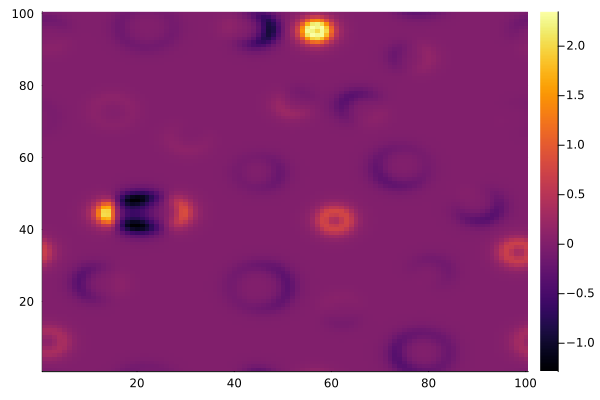

In [23]:
heatmap(sol10[:,:,1,1] - sol10[:,:,1,2])

In [79]:
maxima = findlocalmaxima(sol3[:,:,1,end], edges=false)

2-element Vector{CartesianIndex{2}}:
 CartesianIndex(38, 6)
 CartesianIndex(94, 25)

In [82]:
sol3[:,:,1,end][maxima[2]]

242.94974210036762

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 60.0
u: 2-element Vector{Array{Float64, 3}}:
 [0.7336635446929285 1.670529092877866 … 4.498294423109524 4.346647867723758; 3.4924148955718612 7.197206925405183 … 8.084217249744095 9.244406861511123; … ; 8.338534481533054 3.6131523841038513 … 3.295155127929638 5.904229678435289; 9.817043479487307 3.618757071379193 … 3.1065190965909384 2.26016435978588;;; 0.14994708681109817 0.14994708681109817 … 0.14994708681109817 0.14994708681109817; 0.14994708681109817 0.14994708681109817 … 0.14994708681109817 0.14994708681109817; … ; 0.14994708681109817 0.14994708681109817 … 0.14994708681109817 0.14994708681109817; 0.14994708681109817 0.14994708681109817 … 0.14994708681109817 0.14994708681109817]
 [6.1784909987039205 8.082593039551965 … 3.591143714061327 4.713734305003043; 5.686204305325167 7.414965557989764 … 3.3263010483476756 4.352084203729992; … ; 7.0771318270155605 9.304766589293303 … 4.072198810281451 5.37215

In [17]:
seed = 0
radius=10
@save "sims/test_$(seed)_test_$(radius).jld2" sol10

In [15]:
pwd()

"/home/dionsaur/Lab/polarity"